In [1]:
id = "EA464178-EA359829-EA755826"
PDF_FILE = f"/FERack11_FE_documents2/EMMA_Official_Statement/{id}.pdf"

In [2]:
# id = "US31393LFT52"
# PDF_FILE = f"/FE_Documents/ISIN/{id}.pdf"

In [3]:
import pdfplumber

In [4]:
#importing libraries 
import spacy
 
# Load the English language model
nlp = spacy.load("en_core_web_sm")

/home/soumyadip/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-21 10:22:26.055537: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 10:22:26.118436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 10:22:26.118476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 10:22:26.121002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS w

In [5]:
"""
DRAFT:
Pipeline architecture
MODULE - Meta Extractor -- Will do IOps, takes raw data and provides some output (no strict standard) -- e.g. pdfplumber + opencv morpholigical transformation
MODULE - ANALYZER -- Will take either meta extractor's output or bounding boxes as input. Outputs bounding boxes. Task is analysing and making decision by analysing bounding boxes
MODULE - HYPOTHESIS -- These can take any input but will only produce boolean value as output. False leads to discarding some element and truth leads to accepting some element
MODULE - REDUCER -- These can transform / manipulate data. These will take any input and provide any output.

Barebones pipeline structure:
Meta Extractor (Input OPS) -> Analyzer -> Hypothesis -> Reducer (Ouput OPS)
"""

"\nDRAFT:\nPipeline architecture\nMODULE - Meta Extractor -- Will do IOps, takes raw data and provides some output (no strict standard) -- e.g. pdfplumber + opencv morpholigical transformation\nMODULE - ANALYZER -- Will take either meta extractor's output or bounding boxes as input. Outputs bounding boxes. Task is analysing and making decision by analysing bounding boxes\nMODULE - HYPOTHESIS -- These can take any input but will only produce boolean value as output. False leads to discarding some element and truth leads to accepting some element\nMODULE - REDUCER -- These can transform / manipulate data. These will take any input and provide any output.\n\nBarebones pipeline structure:\nMeta Extractor (Input OPS) -> Analyzer -> Hypothesis -> Reducer (Ouput OPS)\n"

In [6]:
"""
Hypothesis: Table header should be
1. Should not have more than 10 words
2. Tokenising and part of speech tagging should indicate "PROPN" as dominating tag
"""

def can_be_header_line(elem):
    text = elem['text'].encode('ascii', errors='ignore').decode() # Filter out non-ascii characters for now
    # If there are more than 20 words in the line, it's very less likely that it will be a header
    text = text.replace('\t', '')
    if len(text.split(' ')) > 20:
        return False
    doc = nlp(text)
    pos_list = [token.pos_ for token in doc]
    print([(token.text, token.pos_) for token in doc])
    # Check if most of the words are proper noun in the line.
    # If it is, it might be a table heading.
    dom_pos = max(set(pos_list), key = pos_list.count)
    print(dom_pos)
    return dom_pos == "PROPN" or dom_pos == "NOUN"

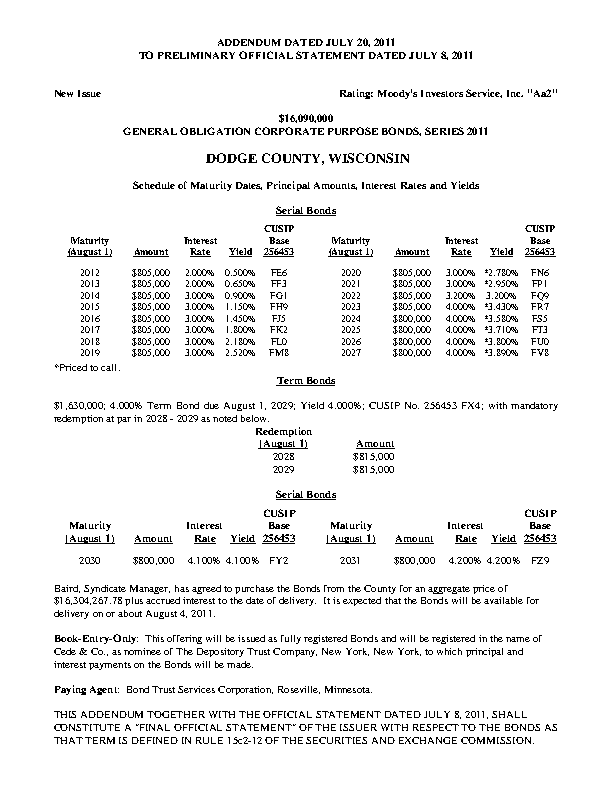

In [7]:
pdf = pdfplumber.open(PDF_FILE)
first_page = pdf.pages[0]
im = first_page.to_image()
# filtered_list = []
# llist = first_page.extract_text_lines()
# prev_line = ""
# for idx, elem in enumerate(llist):
#     # Find lines that have cusip keyword and check if can be a header line
#     if "cusip" in elem['text'].lower():
#         if can_be_header_line(elem):
#             if can_be_header_line(prev_line):
#                 filtered_list.append((idx - 1, prev_line))
#                 im.draw_rect(prev_line)
#             filtered_list.append((idx, elem))
#             im.draw_rect(elem)
#     prev_line = elem
# im.draw_rects(filtered_list)

im.show()

In [8]:
from copy import deepcopy
import re


def convert_words_to_lines(wlist):
    pdf_lines = []
    words_list = []
    text_line = ""
    prev_coords = (0, 0, first_page.width, 0)
    Y_TOLERANCE = 3
    # TODO: Tweak / auto-derive this
    X_SPACE_TOLERANCE = 6
    for word in wlist:
        prev_top, prev_bottom, prev_x0, prev_x1 = prev_coords
        # If the neighbouring word is within the tolerance threashold, include it in line
        if abs(word['top'] - prev_top) <= Y_TOLERANCE or abs(word['bottom'] - prev_bottom) <= Y_TOLERANCE:
            # if abs(prev_x1 - word['x0']) >= X_SPACE_TOLERANCE:
            #     words_list.append({'text': '\t', '__layout_insert': True})
            words_list.append(word)
        else:
            if words_list:
                text_lines = []
                word_groups = [] # When two words are separated by small spaces, consolidated version of them is stored in this array. If there are multiple elements in this array, this means those group of words are seperated by tab / have huge space in between
                last_x1 = words_list[0]['x0']

                for w in words_list:
                    if abs(last_x1 - w['x0']) >= X_SPACE_TOLERANCE:
                        # If the new far-spaced character doesn't have any meaningful data
                        # Skip it
                        if not re.sub('[^A-Za-z0-9]+', '', w['text']):
                            continue
                        text_lines.append("\t" + w['text'])
                        word_groups.append(deepcopy(w))
                    else:
                        text_lines.append(w['text'])
                        if word_groups:
                            last_elem = word_groups[-1]
                            last_elem['x1'] = w['x1']
                            last_elem['text'] = f"{last_elem['text']} {w['text']}"
                            word_groups[-1] = last_elem
                        else:
                            word_groups.append(deepcopy(w))
                    last_x1 = w['x1']

                text_line = " ".join(text_lines)

                pdf_lines.append({
                    'text': text_line,
                    'x0': prev_x0,
                    'x1': prev_x1,
                    'top': prev_top,
                    'bottom': prev_bottom,
                    'words': words_list,
                    'word_groups': word_groups
                })
                # Resetting x0 and x1 as the line has ended
                prev_coords = (prev_top, prev_bottom, first_page.width, 0)
            text_line = word['text']
            words_list = [word]
        prev_coords = (max(word['top'], prev_top), max(word['bottom'], prev_bottom), min(prev_x0, word['x0']), max(prev_x1, word['x1']))
        # print(word['text'], word['top'], word['bottom'])
    # Include last line of the file
    if text_line:
        pdf_lines.append({
                'text': " ".join([w['text'] for w in words_list]),
                'x0': prev_x0,
                'x1': word['x1'],
                'top': max(word['top'], prev_top),
                'bottom': max(word['bottom'], prev_bottom),
                'words': words_list,
                'word_groups': word_groups
            })
    return pdf_lines

[{'x0': 216.51, 'x1': 395.5389, 'top': 37.65167999999994, 'bottom': 48.63167999999996, 'text': 'ADDENDUMDATEDJULY20,2011', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 216.51, 745.74), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 216.51, 'y0': 743.36832, 'x1': 224.43756, 'y1': 754.3483200000001, 'width': 7.92756, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'A', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 37.65167999999994, 'bottom': 48.63167999999996, 'doctop': 37.65167999999994}, {'matrix': (10.98, 0.0, 0.0, 10.98, 224.435364, 745.74), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 224.435364, 'y0': 743.36832, 'x1': 232.362924, 'y1': 754.3483200000001, 'width': 7.92756, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': 

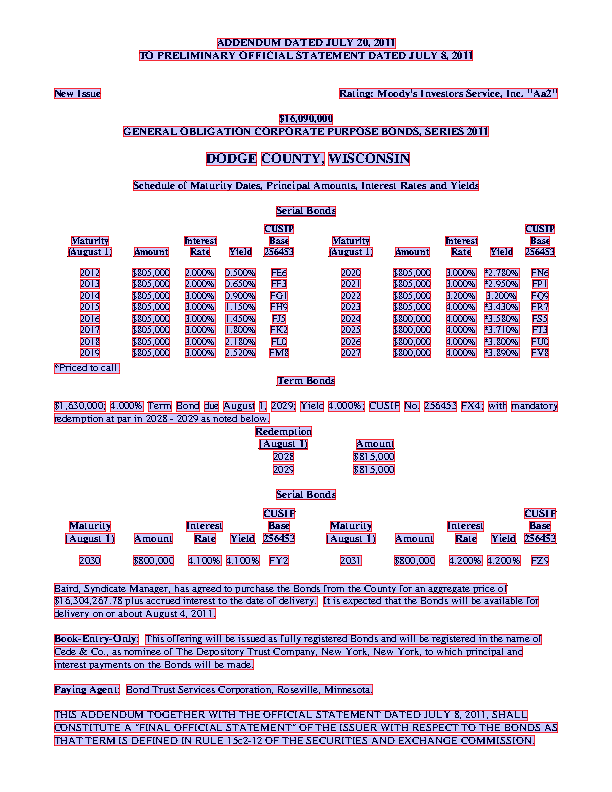

In [9]:
im = first_page.to_image()
wlist = first_page.extract_words()
llist = convert_words_to_lines(wlist)

# Validate if correct
validation_wl = []
for w in llist:
    print(w.get('words', []))
    validation_wl.extend(w.get('words', []))
im.draw_rects(validation_wl)
assert validation_wl == wlist
im.show()

In [10]:
llist[0]

{'text': 'ADDENDUMDATEDJULY20,2011',
 'x0': 216.51,
 'x1': 395.5389,
 'top': 37.65167999999994,
 'bottom': 48.63167999999996,
 'words': [{'x0': 216.51,
   'x1': 395.5389,
   'top': 37.65167999999994,
   'bottom': 48.63167999999996,
   'text': 'ADDENDUMDATEDJULY20,2011',
   'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 216.51, 745.74),
     'fontname': 'TimesNewRomanPS-BoldMT',
     'adv': 0.722,
     'upright': True,
     'x0': 216.51,
     'y0': 743.36832,
     'x1': 224.43756,
     'y1': 754.3483200000001,
     'width': 7.92756,
     'height': 10.980000000000018,
     'size': 10.980000000000018,
     'mcid': None,
     'tag': None,
     'object_type': 'char',
     'page_number': 1,
     'ncs': 'DeviceGray',
     'text': 'A',
     'stroking_color': None,
     'stroking_pattern': None,
     'non_stroking_color': (0,),
     'non_stroking_pattern': None,
     'top': 37.65167999999994,
     'bottom': 48.63167999999996,
     'doctop': 37.65167999999994},
    {'matrix': (10.98, 0.0, 0.0, 10

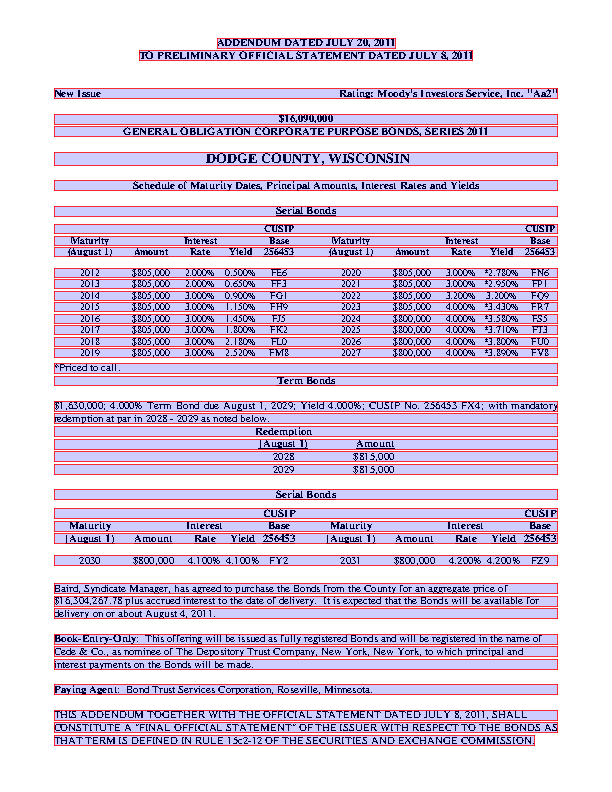

In [11]:
im = first_page.to_image()

# Validate if correct
im.draw_rects(llist)
im.show()

In [12]:
for x in llist:
    print(x['text'])

ADDENDUMDATEDJULY20,2011
TOPRELIMINARYOFFICIALSTATEMENTDATEDJULY8,2011
NewIssue 	Rating:Moody'sInvestorsService,Inc."Aa2"
$16,090,000
GENERALOBLIGATIONCORPORATEPURPOSEBONDS,SERIES2011
DODGE COUNTY, WISCONSIN
ScheduleofMaturityDates,PrincipalAmounts,InterestRatesandYields
SerialBonds
CUSIP 	CUSIP
Base 	Base 	Maturity 	Interest 	Maturity 	Interest
256453 	256453 	(August1) 	Rate 	(August1) 	Rate 	Amount 	Yield 	Amount 	Yield
2012 	$805,000 	2.000% 	0.500% 	FE6 	2020 	$805,000 	3.000% 	*2.780% 	FN6
2013 	$805,000 	2.000% 	0.650% 	FF3 	2021 	$805,000 	3.000% 	*2.950% 	FP1
2014 	$805,000 	3.000% 	0.900% 	FG1 	2022 	$805,000 	3.200% 	3.200% 	FQ9
2015 	$805,000 	3.000% 	1.150% 	FH9 	2023 	$805,000 	4.000% 	*3.430% 	FR7
2016 	$805,000 	3.000% 	1.450% 	FJ5 	2024 	$800,000 	4.000% 	*3.580% 	FS5
2017 	$805,000 	3.000% 	1.800% 	FK2 	2025 	$800,000 	4.000% 	*3.710% 	FT3
2018 	$805,000 	3.000% 	2.180% 	FL0 	2026 	$800,000 	4.000% 	*3.800% 	FU0
2019 	$805,000 	3.000% 	2.520% 	FM8 	2027 	$800,000 	4.0

In [13]:
filtered_list = []
prev_line = ""
for idx, elem in enumerate(llist):
    # Find lines that have cusip keyword and check if can be a header line
    if "cusip" in elem['text'].lower():
        print(elem['text'].replace('\t', ''))
        if can_be_header_line(elem):
            # if can_be_header_line(prev_line):
            #     filtered_list.append((idx - 1, prev_line))
            #     im.draw_rect(prev_line)
            filtered_list.append((idx, elem))
            im.draw_rect(elem)
    prev_line = elem

CUSIP CUSIP
[('CUSIP', 'PROPN'), ('CUSIP', 'PROPN')]
PROPN
$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory
[('$', 'SYM'), ('1,630,000', 'NUM'), (';', 'PUNCT'), ('4.000', 'NUM'), ('%', 'NOUN'), ('Term', 'PROPN'), ('Bond', 'PROPN'), ('due', 'ADJ'), ('August', 'PROPN'), ('1', 'NUM'), (',', 'PUNCT'), ('2029', 'NUM'), (';', 'PUNCT'), ('Yield', 'NOUN'), ('4.000', 'NUM'), ('%', 'NOUN'), (';', 'PUNCT'), ('CUSIP', 'PROPN'), ('No', 'INTJ'), ('.', 'PROPN'), ('256453', 'NUM'), ('FX4', 'PROPN'), (';', 'PUNCT'), ('with', 'ADP'), ('mandatory', 'ADJ')]
PROPN
CUSIP CUSIP
[('CUSIP', 'PROPN'), ('CUSIP', 'PROPN')]
PROPN


In [14]:
filtered_list

[(8,
  {'text': 'CUSIP \tCUSIP',
   'x0': 53.99941199999999,
   'x1': 558.0044700000005,
   'top': 224.22432000000003,
   'bottom': 234.24432000000002,
   'words': [{'x0': 263.97,
     'x1': 294.02599200000003,
     'top': 224.22432000000003,
     'bottom': 234.24432000000002,
     'text': 'CUSIP',
     'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 559.92),
       'fontname': 'TimesNewRomanPS-BoldMT',
       'adv': 0.722,
       'upright': True,
       'x0': 263.97,
       'y0': 557.75568,
       'x1': 271.20444000000003,
       'y1': 567.77568,
       'width': 7.234440000000006,
       'height': 10.019999999999982,
       'size': 10.019999999999982,
       'mcid': None,
       'tag': None,
       'object_type': 'char',
       'page_number': 1,
       'ncs': 'DeviceGray',
       'text': 'C',
       'stroking_color': None,
       'stroking_pattern': None,
       'non_stroking_color': (0,),
       'non_stroking_pattern': None,
       'top': 224.22432000000003,
       'bottom': 23

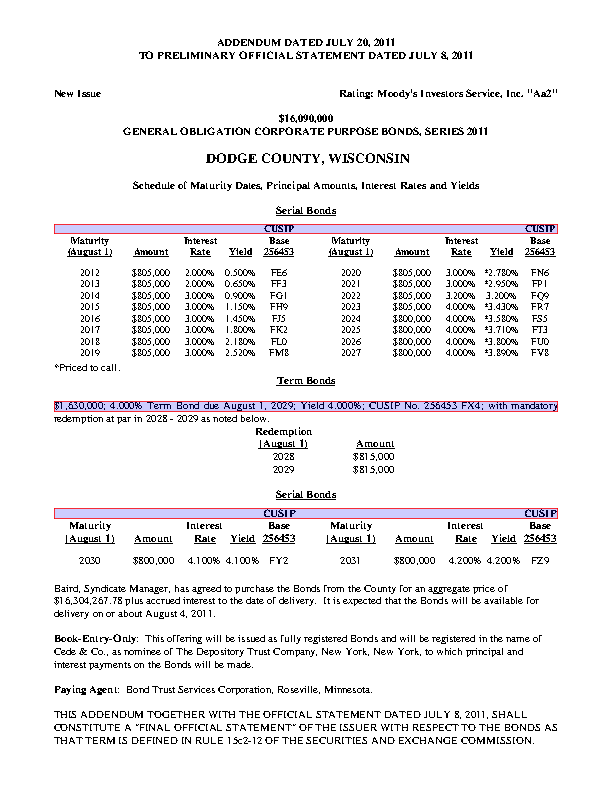

In [15]:
im = first_page.to_image()
for _, line in filtered_list:
    im.draw_rect(line)
im.show()

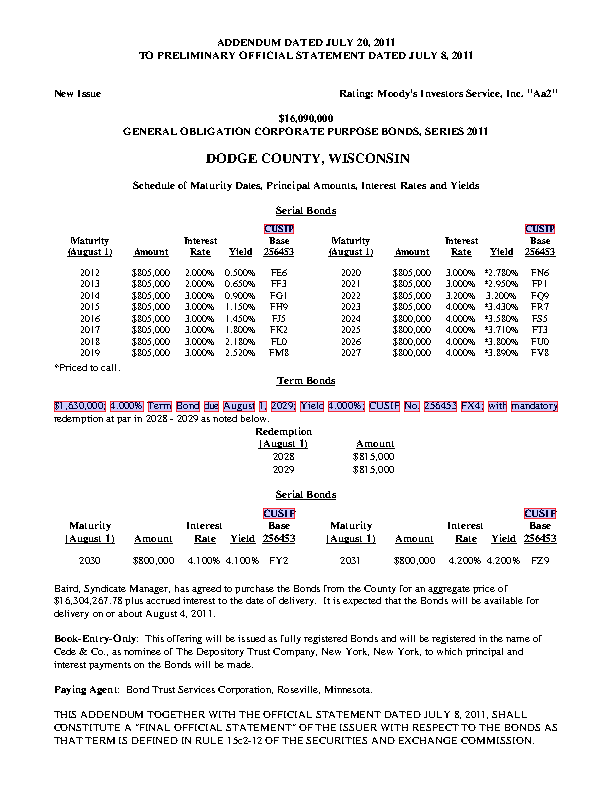

In [16]:
im = first_page.to_image()

for _, line in filtered_list:
    im.draw_rects(line.get('words', []))
im.show()

In [17]:
llist[0]

{'text': 'ADDENDUMDATEDJULY20,2011',
 'x0': 216.51,
 'x1': 395.5389,
 'top': 37.65167999999994,
 'bottom': 48.63167999999996,
 'words': [{'x0': 216.51,
   'x1': 395.5389,
   'top': 37.65167999999994,
   'bottom': 48.63167999999996,
   'text': 'ADDENDUMDATEDJULY20,2011',
   'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 216.51, 745.74),
     'fontname': 'TimesNewRomanPS-BoldMT',
     'adv': 0.722,
     'upright': True,
     'x0': 216.51,
     'y0': 743.36832,
     'x1': 224.43756,
     'y1': 754.3483200000001,
     'width': 7.92756,
     'height': 10.980000000000018,
     'size': 10.980000000000018,
     'mcid': None,
     'tag': None,
     'object_type': 'char',
     'page_number': 1,
     'ncs': 'DeviceGray',
     'text': 'A',
     'stroking_color': None,
     'stroking_pattern': None,
     'non_stroking_color': (0,),
     'non_stroking_pattern': None,
     'top': 37.65167999999994,
     'bottom': 48.63167999999996,
     'doctop': 37.65167999999994},
    {'matrix': (10.98, 0.0, 0.0, 10

In [18]:
for x in filtered_list:
    print(x)

(8, {'text': 'CUSIP \tCUSIP', 'x0': 53.99941199999999, 'x1': 558.0044700000005, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'words': [{'x0': 263.97, 'x1': 294.02599200000003, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'text': 'CUSIP', 'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 559.92), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 263.97, 'y0': 557.75568, 'x1': 271.20444000000003, 'y1': 567.77568, 'width': 7.234440000000006, 'height': 10.019999999999982, 'size': 10.019999999999982, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'C', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'doctop': 224.22432000000003}, {'matrix': (10.02, 0.0, 0.0, 10.02, 271.203438, 559.92), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 271.203438, 'y0'

In [19]:
#TODO: Consolidate multi-line headers
#TODO: Clean up data well
#TODO: Standardize headers

In [20]:
# Vertical scan stop condition (MUNI specific)
"""
1. Try to detect cusips
2. Check alignment of cusips
3. Stop where either of two fails
"""

'\n1. Try to detect cusips\n2. Check alignment of cusips\n3. Stop where either of two fails\n'

In [21]:
import re


def can_be_cusip_part(str):
    str = re.sub(r'[\@\* ]', '', str)
    return len(str) == 3 and str[-1].isdigit()

def can_be_cusip(str):
    str = re.sub(r'[\@\* ]', '', str)
    return len(str) == 9 and can_be_cusip_part(str[-3:])

In [22]:
import pandas as pd
from io import StringIO

In [23]:
filtered_list[0]

(8,
 {'text': 'CUSIP \tCUSIP',
  'x0': 53.99941199999999,
  'x1': 558.0044700000005,
  'top': 224.22432000000003,
  'bottom': 234.24432000000002,
  'words': [{'x0': 263.97,
    'x1': 294.02599200000003,
    'top': 224.22432000000003,
    'bottom': 234.24432000000002,
    'text': 'CUSIP',
    'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 559.92),
      'fontname': 'TimesNewRomanPS-BoldMT',
      'adv': 0.722,
      'upright': True,
      'x0': 263.97,
      'y0': 557.75568,
      'x1': 271.20444000000003,
      'y1': 567.77568,
      'width': 7.234440000000006,
      'height': 10.019999999999982,
      'size': 10.019999999999982,
      'mcid': None,
      'tag': None,
      'object_type': 'char',
      'page_number': 1,
      'ncs': 'DeviceGray',
      'text': 'C',
      'stroking_color': None,
      'stroking_pattern': None,
      'non_stroking_color': (0,),
      'non_stroking_pattern': None,
      'top': 224.22432000000003,
      'bottom': 234.24432000000002,
      'doctop': 

In [24]:
filtered_list

[(8,
  {'text': 'CUSIP \tCUSIP',
   'x0': 53.99941199999999,
   'x1': 558.0044700000005,
   'top': 224.22432000000003,
   'bottom': 234.24432000000002,
   'words': [{'x0': 263.97,
     'x1': 294.02599200000003,
     'top': 224.22432000000003,
     'bottom': 234.24432000000002,
     'text': 'CUSIP',
     'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 559.92),
       'fontname': 'TimesNewRomanPS-BoldMT',
       'adv': 0.722,
       'upright': True,
       'x0': 263.97,
       'y0': 557.75568,
       'x1': 271.20444000000003,
       'y1': 567.77568,
       'width': 7.234440000000006,
       'height': 10.019999999999982,
       'size': 10.019999999999982,
       'mcid': None,
       'tag': None,
       'object_type': 'char',
       'page_number': 1,
       'ncs': 'DeviceGray',
       'text': 'C',
       'stroking_color': None,
       'stroking_pattern': None,
       'non_stroking_color': (0,),
       'non_stroking_pattern': None,
       'top': 224.22432000000003,
       'bottom': 23

In [25]:
filtered_list[0][0]

8

In [26]:
def merge_header_lines(header_lines):
    im = first_page.to_image()

    # If length is same, merge directly
    merged_header = []
    prev_header = None
    for header in header_lines:
        # seperated_header_words = header['text'].split('\t')
        # header_keys = []
        # for w in header['words']:


        # for w in header['words']:
        #     print("Words")
        #     print(w['text'])
        #     print(w['x0'])
        #     print(w['x1'])
        
        # for w in header['word_groups']:
        #     print("Word groups")
        #     print(w['text'])
        #     print(w['x0'])
        #     print(w['x1'])
        if not merged_header:
            merged_header = deepcopy(header['word_groups'])
        else:
            for i, wg in enumerate(header['word_groups']):
                x_mid_point = (wg['x0'] + wg['x1']) / 2
                im.draw_vline(x_mid_point)

                if i >= len(merged_header):
                    merged_header.append(wg)
                    continue

                upper_wg = merged_header[i]
                # If a vertical line going though the mid point also goes through the prev
                # word group's X axis line, they are aligned, so we have to merge them
                if x_mid_point <= upper_wg['x1'] and x_mid_point >= upper_wg['x0']:
                    # merge
                    upper_wg['text'] += f" {wg['text']}"
                    upper_wg['bottom'] = wg['bottom']
                    upper_wg['x0'] = min(upper_wg['x0'], wg['x0'])
                    upper_wg['x1'] = max(upper_wg['x1'], wg['x1'])
                    upper_wg['height'] = abs(upper_wg['top'] - upper_wg['bottom'])
                    upper_wg['width'] = abs(upper_wg['x0'] - upper_wg['x1'])
                else:
                    if x_mid_point < upper_wg['x0']:
                        merged_header.insert(i, wg)


        
        im.draw_rects(header['word_groups'])
        # if not merged_header:
        #     merged_header = header
        #     continue
    im.show()
    return merged_header

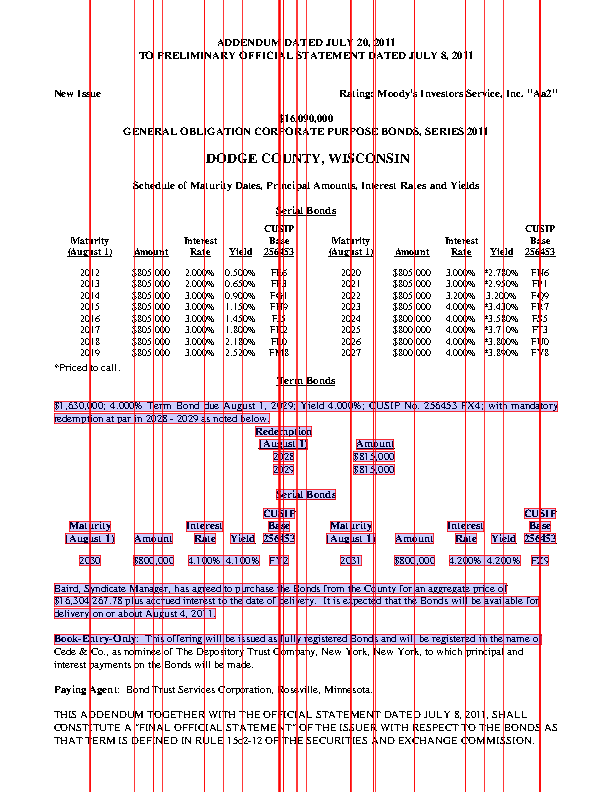

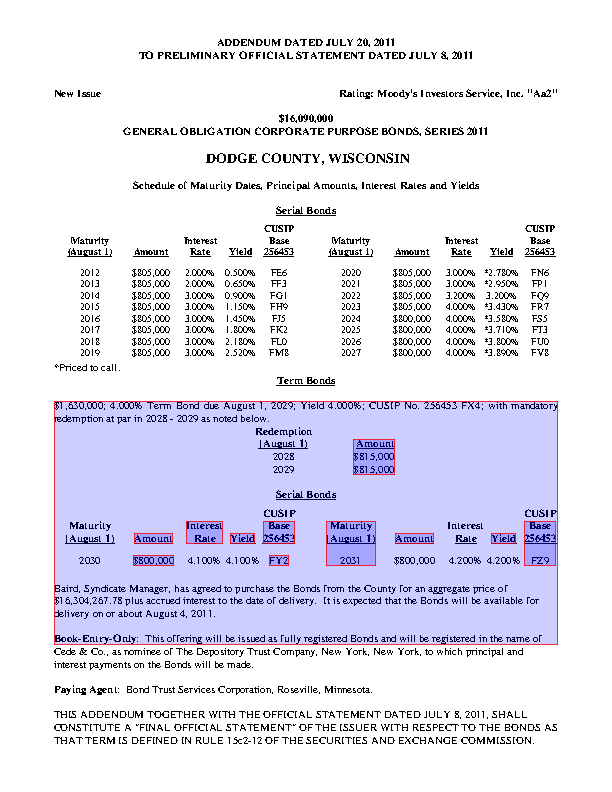

In [27]:
__test_final_header = merge_header_lines(llist[filtered_list[1][0] : 35 + 1])
im = first_page.to_image()
im.draw_rects(__test_final_header)
im.show()

{'text': 'redemptionatparin2028-2029asnotedbelow.', 'x0': 53.99941199999999, 'x1': 558.0687420000006, 'top': 413.49162, 'bottom': 424.47162000000003, 'words': [{'x0': 54.0, 'x1': 270.04906800000003, 'top': 413.49162, 'bottom': 424.47162000000003, 'text': 'redemptionatparin2028-2029asnotedbelow.', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 54.0, 369.90006), 'fontname': 'TimesNewRomanPSMT', 'adv': 0.333, 'upright': True, 'x0': 54.0, 'y0': 367.52837999999997, 'x1': 57.65634, 'y1': 378.50838, 'width': 3.65634, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'r', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 413.49162, 'bottom': 424.47162000000003, 'doctop': 413.49162}, {'matrix': (10.98, 0.0, 0.0, 10.98, 57.65634, 369.90006), 'fontname': 'TimesNewRomanPSMT', 'adv': 0.444, 'upright': True, 'x0': 57.65634, 'y0': 367

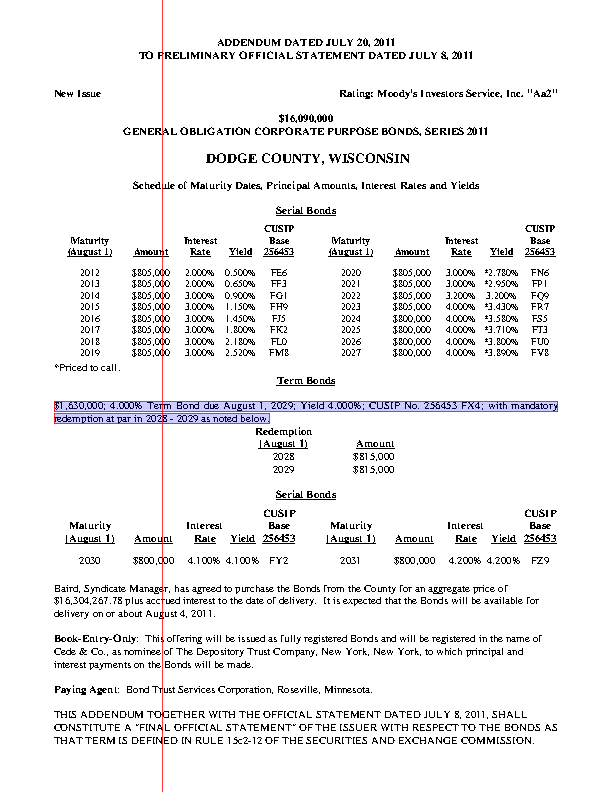

{'text': '$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory redemptionatparin2028-2029asnotedbelow.', 'words': [{'x0': 54.0, 'x1': 558.0687420000006, 'top': 400.83168, 'bottom': 424.47162000000003, 'text': '$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory redemptionatparin2028-2029asnotedbelow.', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 54.0, 382.56), 'fontname': 'TimesNewRomanPSMT', 'adv': 0.5, 'upright': True, 'x0': 54.0, 'y0': 380.18832, 'x1': 59.49, 'y1': 391.16832, 'width': 5.490000000000002, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': '$', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 400.83168, 'bottom': 411.81168, 'doctop': 400.83168}, {'matrix': (10.98, 0.0, 0.0, 10.98, 59.493294, 382.56), 'fontn

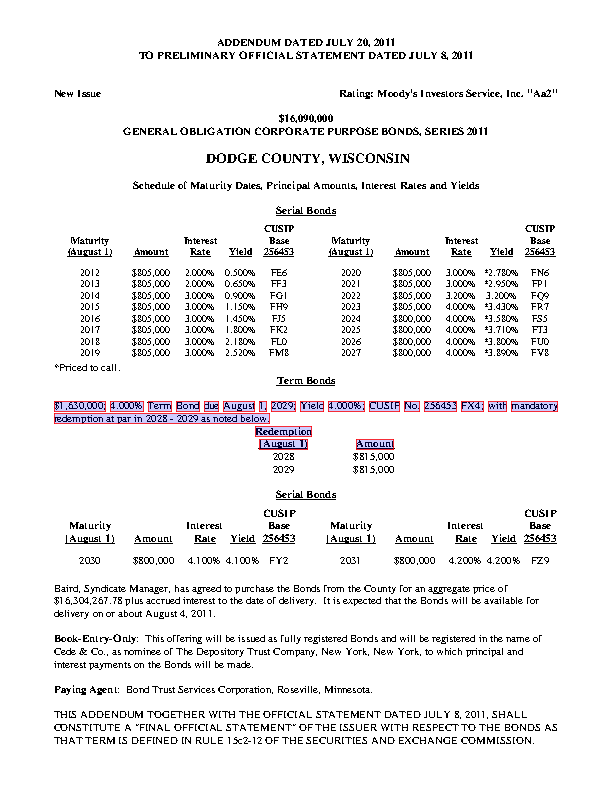

({'text': '$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory redemptionatparin2028-2029asnotedbelow.',
  'words': [{'x0': 54.0,
    'x1': 558.0687420000006,
    'top': 400.83168,
    'bottom': 424.47162000000003,
    'text': '$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory redemptionatparin2028-2029asnotedbelow.',
    'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 54.0, 382.56),
      'fontname': 'TimesNewRomanPSMT',
      'adv': 0.5,
      'upright': True,
      'x0': 54.0,
      'y0': 380.18832,
      'x1': 59.49,
      'y1': 391.16832,
      'width': 5.490000000000002,
      'height': 10.980000000000018,
      'size': 10.980000000000018,
      'mcid': None,
      'tag': None,
      'object_type': 'char',
      'page_number': 1,
      'ncs': 'DeviceGray',
      'text': '$',
      'stroking_color': None,
      'stroking_pattern': None,
      'non_stroking_color': (0,),
      'non_strok

In [28]:
def detect_multiline_header(primary_header, lines, header_tolerance = 2):
    primary_header_index, primary_header_content = primary_header
    im = first_page.to_image()

    im.draw_rects(primary_header_content['words'])

    neighbouring_lines_map = {}

    # Check for continuation below

    # Downward scan range: from next line of the primary header till 1 line more than header tolerance (inclusive)
    for li in range(min(primary_header_index + 1, len(llist)), min(len(llist), primary_header_index + 1 + header_tolerance + 1)):
        im.draw_rects(llist[li]['words'])
        print(llist[li])
        row_vals = llist[li]['text'].split('\t')
        # Remove any cell that only contains any special character and nothing else
        row_vals = [re.sub('[^A-Za-z0-9]+', '', val) for val in row_vals if re.sub('[^A-Za-z0-9]+', '', val)]
        print(len(row_vals))
        print(row_vals)
        doc = nlp(" ".join(row_vals))
        pos_list = [token.pos_ if token.pos_ != "PROPN" else "NOUN" for token in doc]
        print([(token.text, token.pos_) for token in doc])
        neighbouring_lines_map[li] = {
            'length': len(row_vals),
            'type_tags': pos_list
        }
    print(primary_header)

    possible_header_start_idx = primary_header_index
    possible_header_end_idx = primary_header_index
    neighbouring_lines_map = dict(sorted(neighbouring_lines_map.items(), reverse=True))

    print(neighbouring_lines_map)
    data_type_list = []

    for idx, elem in neighbouring_lines_map.items():
        if not data_type_list:
            data_type_list = elem['type_tags']
        
        if data_type_list != elem['type_tags']:
            possible_header_end_idx = max(idx, primary_header_index)
    
    merged_header_list = merge_header_lines(llist[possible_header_start_idx:possible_header_end_idx + 1])
    merged_header = {
        'text': "\t".join([hw['text'] for hw in merged_header_list]),
        'words': merged_header_list
    }
    print(merged_header)
    im.show()
    # Returns: new merged header, last header index
    return merged_header, possible_header_end_idx

detect_multiline_header(filtered_list[1], llist)

In [29]:
from dateutil import parser

def normalize_headers(headers):
    """
    Returns normalised version of the headers along with their original representation.
    Also detects any repeatation and returns the details
    """
    HEADER_MAP = {
        'matur': 'maturitydate',
        'due': 'maturitydate',
        'principal': 'amountissued',
        'amount': 'amountissued',
        'yield': 'yield',
        'interest': 'interest_rate',
        'cupon': 'interest_rate',
        'price': 'issue_price',
        'cusip': 'cusip',
        'rate': 'interest_rate'
    } | dict((m[0].lower(), 'maturitydate') for m in parser.parserinfo.MONTHS)
    first_header = ''
    first_header_indicies = []
    results = []
    for idx, header in enumerate(headers):
        normalized_value = next((v for k, v in HEADER_MAP.items() if k in header.replace(' ', '').lower()), header)
        if not first_header:
            first_header = normalized_value
            first_header_indicies.append(idx)
        else:
            if first_header == normalized_value:
                first_header_indicies.append(idx)
        
        results.append({
            'header': normalized_value,
            'original_string': header
        })
    
    return results, first_header_indicies

normalize_headers('Due March 1\tPrincipal Amount\tInterest Rate\tYield\tCUSIP† Number\tDue March 1\tPrincipal Amount\tInterest Rate\tYield\tCUSIP† Number'.split('\t'))

([{'header': 'maturitydate', 'original_string': 'Due March 1'},
  {'header': 'amountissued', 'original_string': 'Principal Amount'},
  {'header': 'interest_rate', 'original_string': 'Interest Rate'},
  {'header': 'yield', 'original_string': 'Yield'},
  {'header': 'cusip', 'original_string': 'CUSIP† Number'},
  {'header': 'maturitydate', 'original_string': 'Due March 1'},
  {'header': 'amountissued', 'original_string': 'Principal Amount'},
  {'header': 'interest_rate', 'original_string': 'Interest Rate'},
  {'header': 'yield', 'original_string': 'Yield'},
  {'header': 'cusip', 'original_string': 'CUSIP† Number'}],
 [0, 5])

Searching for header {'text': 'CUSIP \tCUSIP', 'x0': 53.99941199999999, 'x1': 558.0044700000005, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'words': [{'x0': 263.97, 'x1': 294.02599200000003, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'text': 'CUSIP', 'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 559.92), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 263.97, 'y0': 557.75568, 'x1': 271.20444000000003, 'y1': 567.77568, 'width': 7.234440000000006, 'height': 10.019999999999982, 'size': 10.019999999999982, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'C', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'doctop': 224.22432000000003}, {'matrix': (10.02, 0.0, 0.0, 10.02, 271.203438, 559.92), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0':

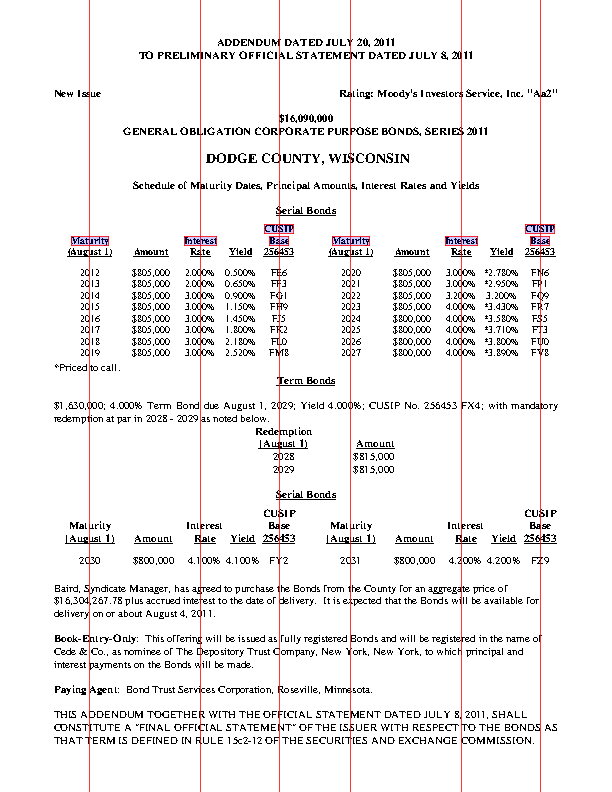

{'text': 'CUSIP Base\tCUSIP Base\tMaturity\tInterest\tMaturity\tInterest', 'words': [{'x0': 263.97, 'x1': 294.02599200000003, 'top': 224.22432000000003, 'bottom': 245.764314, 'text': 'CUSIP Base', 'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 559.92), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 263.97, 'y0': 557.75568, 'x1': 271.20444000000003, 'y1': 567.77568, 'width': 7.234440000000006, 'height': 10.019999999999982, 'size': 10.019999999999982, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'C', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 224.22432000000003, 'bottom': 234.24432000000002, 'doctop': 224.22432000000003}, {'matrix': (10.02, 0.0, 0.0, 10.02, 271.203438, 559.92), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 271.203438, 'y0': 557.75568, 'x1': 278.437878, 'y1': 567.77568, 'width': 7.234440

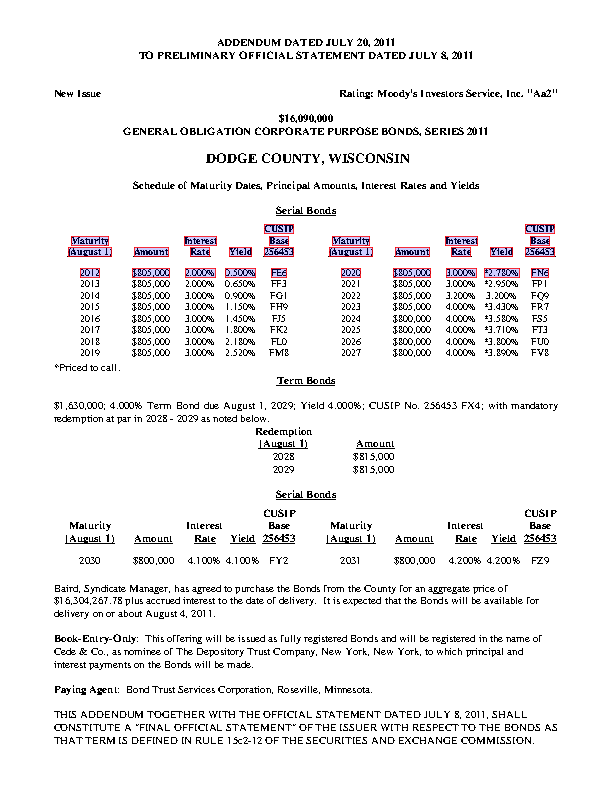

{'text': '256453 \t256453 \t(August1) \tRate \t(August1) \tRate \tAmount \tYield \tAmount \tYield', 'x0': 53.99941199999999, 'x1': 558.0044700000005, 'top': 247.26432, 'bottom': 257.28432, 'words': [{'x0': 263.97, 'x1': 294.03000000000003, 'top': 247.26430800000003, 'bottom': 257.284308, 'text': '256453', 'chars': [{'matrix': (10.02, 0.0, 0.0, 10.02, 263.97, 536.880012), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.5, 'upright': True, 'x0': 263.97, 'y0': 534.715692, 'x1': 268.98, 'y1': 544.735692, 'width': 5.009999999999991, 'height': 10.019999999999982, 'size': 10.019999999999982, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': '2', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 247.26430800000003, 'bottom': 257.284308, 'doctop': 247.26430800000003}, {'matrix': (10.02, 0.0, 0.0, 10.02, 268.98, 536.880012), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.5, 'upright': T

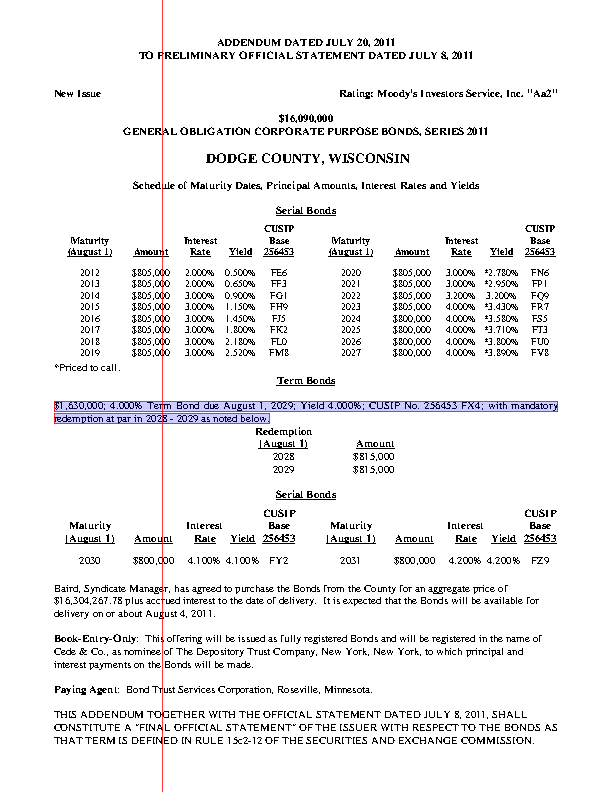

{'text': '$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory redemptionatparin2028-2029asnotedbelow.', 'words': [{'x0': 54.0, 'x1': 558.0687420000006, 'top': 400.83168, 'bottom': 424.47162000000003, 'text': '$1,630,000; 4.000% Term Bond due August 1, 2029; Yield 4.000%; CUSIP No. 256453 FX4; with mandatory redemptionatparin2028-2029asnotedbelow.', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 54.0, 382.56), 'fontname': 'TimesNewRomanPSMT', 'adv': 0.5, 'upright': True, 'x0': 54.0, 'y0': 380.18832, 'x1': 59.49, 'y1': 391.16832, 'width': 5.490000000000002, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': '$', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 400.83168, 'bottom': 411.81168, 'doctop': 400.83168}, {'matrix': (10.98, 0.0, 0.0, 10.98, 59.493294, 382.56), 'fontn

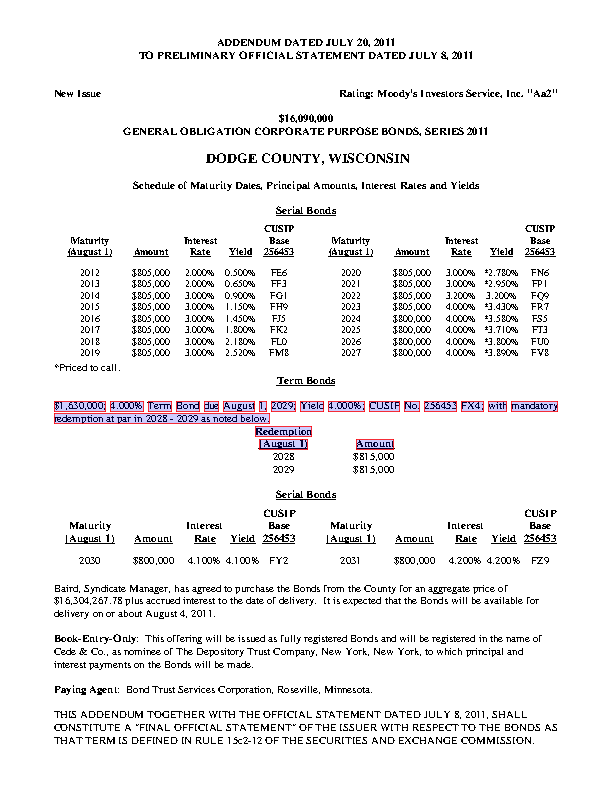

{'text': 'Redemption', 'x0': 53.99941199999999, 'x1': 558.0687420000006, 'top': 426.15156, 'bottom': 437.13156000000004, 'words': [{'x0': 254.819808, 'x1': 312.16724999999997, 'top': 426.15156, 'bottom': 437.13156000000004, 'text': 'Redemption', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 254.819808, 357.24012), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.722, 'upright': True, 'x0': 254.819808, 'y0': 354.86843999999996, 'x1': 262.747368, 'y1': 365.84844, 'width': 7.92756, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'R', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 426.15156, 'bottom': 437.13156000000004, 'doctop': 426.15156}, {'matrix': (10.98, 0.0, 0.0, 10.98, 262.748466, 357.24012), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.444, 'upright': True, 'x0': 262.748466, 'y0': 354.86843999999996, 'x1': 2

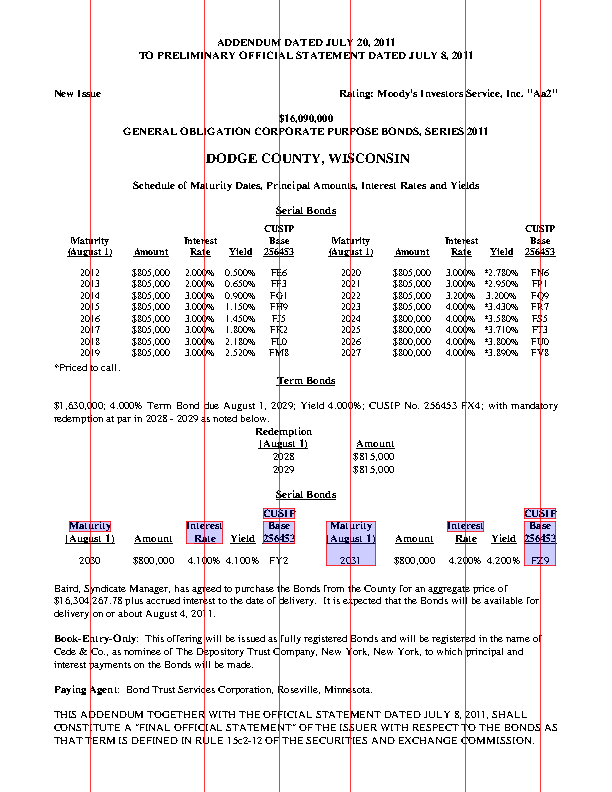

{'text': 'Maturity\tInterest Rate\tCUSIP\tInterest\tBase 256453\tCUSIP Base 256453 FZ9', 'words': [{'x0': 68.67, 'x1': 111.36792600000001, 'top': 520.7715800000001, 'bottom': 531.7515800000001, 'text': 'Maturity', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 68.67, 262.6201), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.9440000000000001, 'upright': True, 'x0': 68.67, 'y0': 260.24841999999995, 'x1': 79.03512, 'y1': 271.22841999999997, 'width': 10.365120000000005, 'height': 10.980000000000018, 'size': 10.980000000000018, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': 'M', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 520.7715800000001, 'bottom': 531.7515800000001, 'doctop': 520.7715800000001}, {'matrix': (10.98, 0.0, 0.0, 10.98, 79.036218, 262.6201), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.5, 'upright': True, 'x0': 79.036218, 'y0': 260.24841999999995, 'x1': 84.

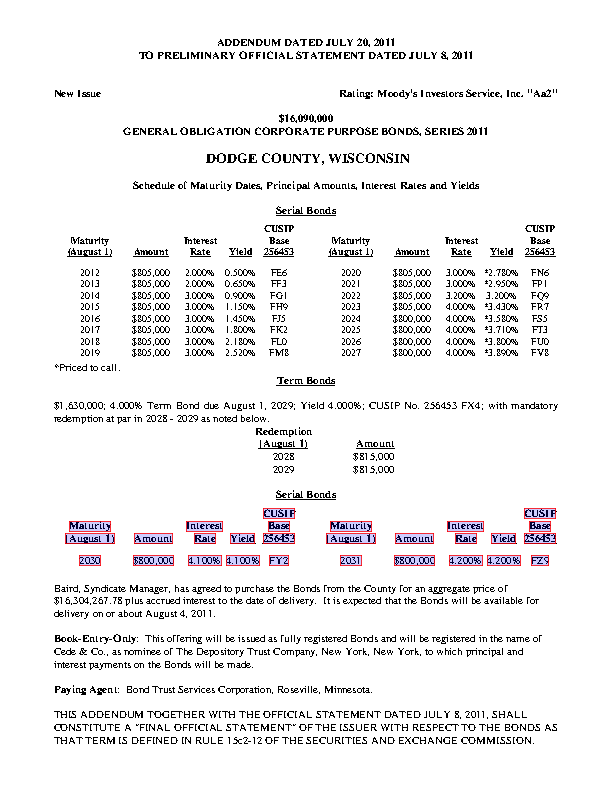

{'text': '(August1) \tRate \t(August1) \tRate \t256453 \t256453 \tAmount \tYield \tAmount \tYield', 'x0': 53.99941199999999, 'x1': 558.0687420000006, 'top': 533.4316799999999, 'bottom': 544.4116799999999, 'words': [{'x0': 65.429802, 'x1': 114.55651800000001, 'top': 533.4315200000001, 'bottom': 544.41152, 'text': '(August1)', 'chars': [{'matrix': (10.98, 0.0, 0.0, 10.98, 65.429802, 249.96015999999997), 'fontname': 'TimesNewRomanPS-BoldMT', 'adv': 0.333, 'upright': True, 'x0': 65.429802, 'y0': 247.58847999999998, 'x1': 69.086142, 'y1': 258.56847999999997, 'width': 3.65634, 'height': 10.97999999999999, 'size': 10.97999999999999, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 1, 'ncs': 'DeviceGray', 'text': '(', 'stroking_color': None, 'stroking_pattern': None, 'non_stroking_color': (0,), 'non_stroking_pattern': None, 'top': 533.4315200000001, 'bottom': 544.41152, 'doctop': 533.4315200000001}, {'matrix': (10.98, 0.0, 0.0, 10.98, 69.08724, 249.96015999999997), 'fontname': 

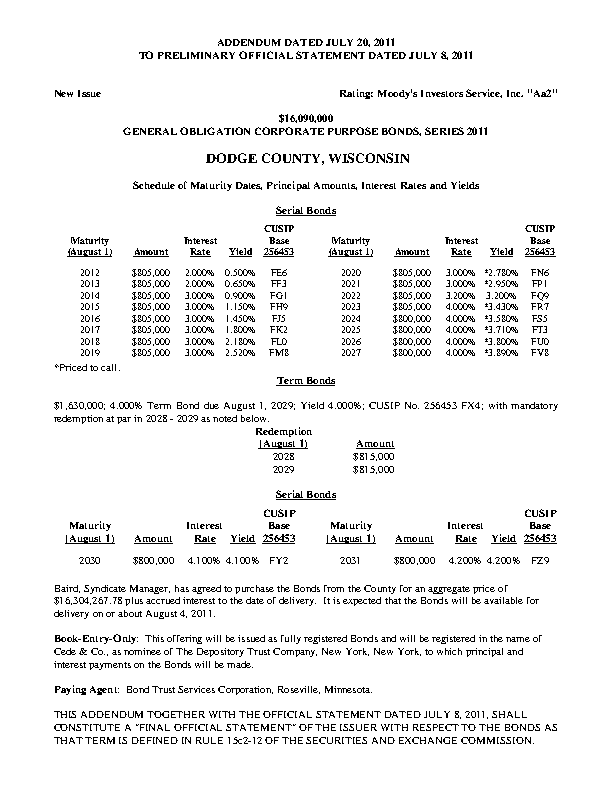

In [30]:
# TEST: Minimal stop condition based on cell value
from io import StringIO


im = first_page.to_image()

df_data_list = []

for idx, (line_index, line) in enumerate(filtered_list):
    print(f"Searching for header {line}")
    end_idx = filtered_list[min(len(filtered_list) - 1, idx + 1)][0]
    if end_idx == line_index:
        end_idx = len(llist)
    df_data = StringIO()
    print(f"Start idx: {min(len(llist), line_index + 1)}")
    print(f"End idx: {min(len(llist), end_idx)}")
    header, line_index = detect_multiline_header((line_index, line), llist)
    header_props, header_repeats = normalize_headers(header['text'].split('\t'))
    df_data.write('\t'.join([h['header'] for h in header_props]))
    df_data.write('\n')
    # df_data.write(header['text'] + '\n')
    for li in range(min(len(llist), line_index + 1), min(len(llist), end_idx)):
        next_line = llist[li]
        
        words = next_line.get('words', [])
        # Stop condition check

        # Breaking logic
        # if "2023" in next_line['text']:
        #     break
        found_possible_cusip = False
        print(next_line)
        for cell_data in next_line['text'].split('\t'):
            if can_be_cusip(cell_data) or can_be_cusip_part(cell_data):
                found_possible_cusip = True
                break
        
        if not found_possible_cusip:
            break
        
        im.draw_rects(words)
        print(next_line['text'])
        df_data.write(next_line['text'] + '\n')

    df_data_list.append((df_data, header_repeats))
    # im.draw_rects(llist[line_index : end_idx if end_idx != line_index else -1])
im.show()

In [31]:
df_data_list

[(<_io.StringIO at 0x7f60ee44a0e0>, [0, 1]),
 (<_io.StringIO at 0x7f60ee44b910>, [0]),
 (<_io.StringIO at 0x7f60ee44a680>, [0])]

In [32]:
buf = StringIO()
print(buf.write("hello"))
buf.seek(0)
print(buf.readlines())

5
['hello']


In [33]:
"abcd"[0:None]

'abcd'

In [34]:
def remove_suffix(value):
    limit = value.find('.')
    return value[: None if limit == -1 else limit]

remove_suffix('maturitydate.1')

'maturitydate'

In [35]:
df_data_list

[(<_io.StringIO at 0x7f60ee44a0e0>, [0, 1]),
 (<_io.StringIO at 0x7f60ee44b910>, [0]),
 (<_io.StringIO at 0x7f60ee44a680>, [0])]

In [36]:
final_dfs = []

for tab, repeats in df_data_list:
    tab.seek(0)
    df = pd.read_csv(tab, sep='\t', lineterminator='\n')
    if len(repeats) > 1:
        for idx, repeat_idx in enumerate(repeats):
            upper_limit = None if idx + 1 >= len(repeats) else repeats[idx + 1]
            sub_df = df.iloc[:,repeat_idx:upper_limit]
            sub_df.columns = [remove_suffix(coln) for coln in sub_df.columns]
            # sub_df.rename(remove_suffix, axis='columns', copy=True)
            final_dfs.append(sub_df)
    else:
        final_dfs.append(df)
    tab.close()

In [37]:
final_dfs[0]

Empty DataFrame
Columns: [cusip]
Index: []

In [38]:
final_dfs[0].replace(r'[%\*\$ , ]|\((.*?)\)', '', regex=True)

Empty DataFrame
Columns: [cusip]
Index: []

In [39]:
pdf.close()

In [40]:
ord('†')

8224